In [ ]:
import torch
import tqdm
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torchvision import models, datasets, transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = models.resnet18().to(device)
T = transforms.Compose(
    [
     transforms.Resize((224, 224)),
     transforms.ToTensor()
    ]
)
data = datasets.CIFAR10("root/", download=True, train=True, transform=T)
loader = DataLoader(data, batch_size=64)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()
x, y = next(iter(loader))
print(len(data), len(loader), x.shape, y.shape, device)

Files already downloaded and verified
50000 782 torch.Size([64, 3, 224, 224]) torch.Size([64]) cuda


In [ ]:
class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, n_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.n_iter = n_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.n_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

In [ ]:
class LRFinder():
    def __init__(self, net, optimizer, loss_fn, device):
        self.optimizer = optimizer
        self.net = net
        self.loss_fn = loss_fn
        self.device = device
        torch.save(net.state_dict(), 'init_params.pth.tar')

    def iterate(self, loader, end_lr=10, n_iters=100, smooth_f=0.05, diverge_th=5):
        self.lrs = []
        self.losses = []
        stopped_search = False
        best_loss = float("inf")
        lr_scheduler = ExponentialLR(self.optimizer, end_lr, n_iters)  

        for i in tqdm.trange(n_iters):
            loss = self.get_loss(loader)
            lr = lr_scheduler.get_last_lr()[0]
            self.lrs.append(lr)
            lr_scheduler.step()
            if i > 0:
                loss = smooth_f * loss + (1 - smooth_f) * self.losses[-1]
            if loss < best_loss:
                best_loss = loss

            self.losses.append(loss)
            if loss > diverge_th * best_loss:
                print("")
                print("stopping the search, loss has diverged!!")
                stopped_search = True
                break

        if stopped_search == False: 
            print("")
            print("finished the lr search!!")

    def get_loss(self, loader):
        self.net.train()
        self.optimizer.zero_grad()
        x, y = next(iter(loader))
        x = x.to(self.device)
        y = y.to(self.device)
        y_pred = self.net(x)
        loss = self.loss_fn(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def plot(self, skip_start=5, skip_end=5):
        if skip_end == 0:
            lrs = self.lrs[skip_start:]
            losses = self.losses[skip_start:]
        else:
            lrs = self.lrs[skip_start:-skip_end]
            losses = self.losses[skip_start:-skip_end]
        
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(lrs, losses)
        ax.set_xscale("log")
        ax.set_xlabel("lr")
        ax.set_ylabel("loss")
        ax.grid(True, "both", "x")
        plt.show()

In [ ]:
lr_finder = LRFinder(net, optimizer, loss_fn, device)
lr_finder.iterate(loader, end_lr=10, n_iters=100)

 87%|████████▋ | 87/100 [00:23<00:03,  3.79it/s]


stopping the search, loss has diverged!!


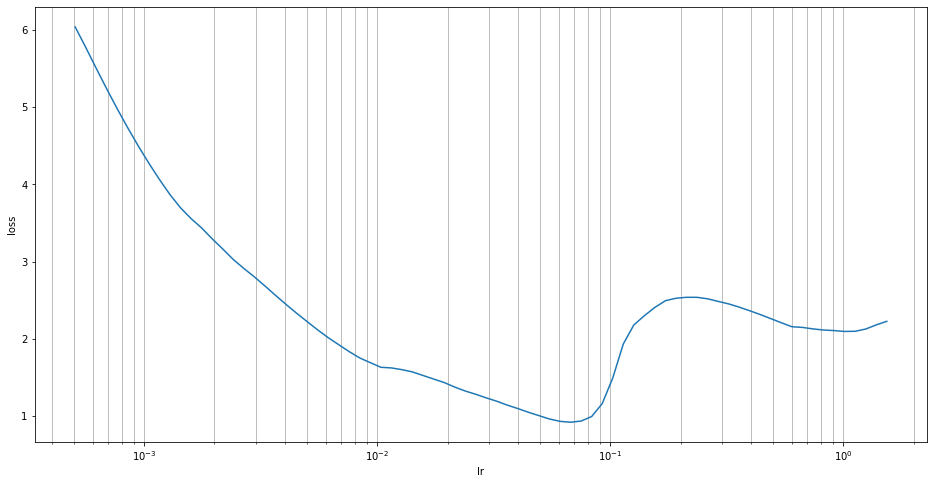

In [ ]:
lr_finder.plot()

In [ ]:
# find the lr where the loss began to flatten and reduce it by a factor of 10
# in this plot, loss began to flatten at 6e-2, so reduction by a factor of 10 gives 6e-3
found_lr = 6e-2
net.load_state_dict(torch.load("init_params.pth.tar")) # reload the initial parameters
optimizer = torch.optim.Adam(net.parameters(), lr=found_lr/10) # reload the optimizer with the lr = (best found lr / 10)

# another approach(descriminative fine-tuning):
# first layer has lr = (found_lr / 10) and the last layer has lr = found_lr, and the lrs of the intermediate layers are gradually increased
# params = [
#           {"params": net.first_layer.parmaeters(), "lr": found_lr/10},
#           {"params": net.second_layer.parameters(), "lr": found_lr/10},
#           {"params": net.3rd.parameters(), "lr": found_lr/8},
#           {"params": net.4th.parameters(), "lr": found_lr/6},
#           {"params": net.5th.parameters(), "lr": found_lr/4},
#           {"params": net.6th.parameters(), "lr": found_lr/2}.
#           {"params": net.final_layer.parameters()} # final_layer has lr = found_lr
# ]
# optimizer = torch.optim.Adam(params, lr=found_lr)